<a href="https://colab.research.google.com/github/shahriarivari/Persian_sentiment_analysis/blob/main/Persian_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pip installs


In [ ]:
!pip install tokenizers
!pip install datasets
!pip install -U accelerate
!pip install -U transformers

# BERT pre-training

## Initial imports

In [ ]:
import os
from tokenizers import BertWordPieceTokenizer
from transformers import BertModel, BertConfig, BertForMaskedLM
from transformers import DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
from datasets import load_dataset, Dataset
from transformers import TrainerCallback
import logging

## Importing dataset from huggingface hub

In [ ]:
# You should just change this part in order to download your
# parts of corpus.
indices = {
    "train": [81, 14, 3, 94, 35,
              # 41, 28, 67, 55, 79
              ],
    "test": [0,
            #  1
             ]
}

N_FILES = {
    "train": 126,
    "test": 3
}
_BASE_URL = "https://huggingface.co/datasets/SLPL/naab/resolve/main/data/"
data_url = {
    "train": [_BASE_URL + "train-{:05d}-of-{:05d}.txt".format(x, N_FILES["train"]) for x in range(N_FILES["train"])],
    "test": [_BASE_URL + "test-{:05d}-of-{:05d}.txt".format(x, N_FILES["test"]) for x in range(N_FILES["test"])],
}
for index in indices['train']:
    assert index < N_FILES['train']
for index in indices['test']:
    assert index < N_FILES['test']
data_files = {
    "train": [data_url['train'][i] for i in indices['train']],
    "test": [data_url['test'][i] for i in indices['test']]
}


In [ ]:
dataset = load_dataset('text', data_files=data_files, use_auth_token=False)
# dataset2 = load_dataset('text', data_files=data_files["train"][3:6], use_auth_token=False)
# dataset3 = load_dataset('text', data_files=data_files["train"][6:], use_auth_token=False)
# dataset4 = load_dataset('text', data_files=data_files["test"], use_auth_token=False)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

## Setting paths and file names

In [ ]:
# Set your paths and file names
tokenizer_output_dir = "bert_tokenizer"
os.mkdir(tokenizer_output_dir)
pretrained_model_output_dir = "bert_pretrained_model"
os.mkdir(pretrained_model_output_dir)

## tokenizing the dataset

In [ ]:
vocab_size = 20_000
min_frequency = 2
max_length = 512
special_tokens = ["[PAD]", "[MASK]", "[CLS]", "[SEP]", "[UNK]"]

In [ ]:
from transformers import BertTokenizerFast
# Load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained(tokenizer_output_dir)

In [ ]:
max_sequence_length = max_length

# Define a custom tokenize function
# def tokenize_function(example):
#     # Ensure that the "text" field is a string
#     if not isinstance(example["text"], str):
#         raise TypeError("Input 'text' must be a string.")

#     # Tokenize the text using BertTokenizerFast
#     encoded = tokenizer(example["text"], truncation=True, padding='max_length',
#                         return_special_tokens_mask=True,
#                         max_length=max_sequence_length, return_tensors='pt')

#     return {
#         'input_ids': encoded['input_ids'].squeeze(),
#         'attention_mask': encoded['attention_mask'].squeeze(),
#     }

# # Use the map function to tokenize the "train" split
# tokenized_train_dataset = dataset['train'].map(tokenize_function, num_proc= 4)
# tokenized_test_dataset = dataset['test'].map(tokenize_function, num_proc=4)

def batch_tokenize_function(batch):
    # Tokenize the text using BertTokenizerFast
    encoded = tokenizer(batch["text"], truncation=True, padding='max_length',
                        return_special_tokens_mask=True,
                        max_length=max_length, return_tensors='pt')

    return {
        'input_ids': encoded['input_ids'],
        'attention_mask': encoded['attention_mask'],
    }
tokenized_train_dataset = dataset['train'].map(batch_tokenize_function, batched=True , num_proc= 2)
tokenized_test_dataset = dataset['test'].map(batch_tokenize_function, batched=True, num_proc= 2)

Map (num_proc=2):   0%|          | 0/10857786 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/4674154 [00:00<?, ? examples/s]

In [ ]:
tokenized_train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
tokenized_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

## Model Configuration

In [ ]:
vocab_size = 10000
max_length = 256
# Model Configuration
model_config = BertConfig(
    vocab_size=vocab_size,
    hidden_size=128,  # Adjust as needed
    num_attention_heads=8,  # Adjust as needed
    num_hidden_layers=2,  # Adjust as needed
    max_position_embeddings=max_length,
)
# Model Initialization
model = BertForMaskedLM(config=model_config)

In [ ]:
# Calculate parameters for transformer layers
num_parameters_transformer = (
    (model_config.num_attention_heads * model_config.hidden_size) * 3 +
    model_config.hidden_size * 4
) * model_config.num_hidden_layers

# Calculate parameters for embedding layer
num_parameters_embedding = (
    vocab_size * model_config.hidden_size +  # Token embeddings
    model_config.hidden_size +  # Position embeddings
    max_length * model_config.hidden_size  # Position embeddings for each position
)

# Total number of parameters
total_parameters = num_parameters_transformer + num_parameters_embedding

print("Number of parameters for transformer layers:", num_parameters_transformer)
print("Number of parameters for embedding layer:", num_parameters_embedding)
print("Total number of parameters in the model:", total_parameters)

Number of parameters for transformer layers: 7168
Number of parameters for embedding layer: 1312896
Total number of parameters in the model: 1320064


In [ ]:
from sklearn.model_selection import ParameterGrid
import numpy as np
import pandas as pd

# Function to calculate the number of parameters
def calculate_parameters(config):
    num_parameters_transformer = (
        (config['num_attention_heads'] * config['hidden_size']) * 3 +
        config['hidden_size'] * 4
    ) * config['num_hidden_layers']

    num_parameters_embedding = (
        config['vocab_size'] * config['hidden_size'] +  # Token embeddings
        config['hidden_size'] +  # Position embeddings
        config['max_position_embeddings'] * config['hidden_size']  # Position embeddings for each position
    )

    total_parameters = num_parameters_transformer + num_parameters_embedding
    return num_parameters_embedding, num_parameters_transformer, total_parameters

# Define the parameter grid
param_grid = {
    'vocab_size': [10000],  # Adjust as needed
    'hidden_size': [8,16,32, 64, 128],  # Adjust as needed
    'num_attention_heads': [2, 4,8],  # Adjust as needed
    'num_hidden_layers': [1,2,3, 4],  # Adjust as needed
    'max_position_embeddings': [128, 256],  # Adjust as needed
}

# Generate all combinations of hyperparameters
param_combinations = list(ParameterGrid(param_grid))

# Initialize an empty DataFrame
results_df = pd.DataFrame(columns=['vocab_size', 'hidden_size', 'num_attention_heads',
                                    'num_hidden_layers', 'max_position_embeddings',
                                    'embedding_params', 'transformer_params', 'total_params'])

# Perform grid search
for params in param_combinations:
    config = BertConfig(**params)
    embedding_params, transformer_params, total_params = calculate_parameters(params)

    # Append results to the DataFrame
    results_df = results_df.append({
        'vocab_size': params['vocab_size'],
        'hidden_size': params['hidden_size'],
        'num_attention_heads': params['num_attention_heads'],
        'num_hidden_layers': params['num_hidden_layers'],
        'max_position_embeddings': params['max_position_embeddings'],
        'embedding_params': embedding_params,
        'transformer_params': transformer_params,
        'total_params': total_params,
    }, ignore_index=True)

# Print and display the results DataFrame
print(results_df)


<ipython-input-3-32f038cfb194>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-3-32f038cfb194>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-3-32f038cfb194>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-3-32f038cfb194>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-3-32f038cfb194>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = resul

    vocab_size hidden_size num_attention_heads num_hidden_layers  \
0        10000           8                   2                 1   
1        10000           8                   2                 2   
2        10000           8                   2                 3   
3        10000           8                   2                 4   
4        10000           8                   4                 1   
..         ...         ...                 ...               ...   
115      10000         128                   4                 4   
116      10000         128                   8                 1   
117      10000         128                   8                 2   
118      10000         128                   8                 3   
119      10000         128                   8                 4   

    max_position_embeddings embedding_params transformer_params total_params  
0                       128            81032                 80        81112  
1                       1

<ipython-input-3-32f038cfb194>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-3-32f038cfb194>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


In [ ]:
# Save the DataFrame to an Excel file
results_df.to_excel('parameter_results.xlsx', index=False)

In [ ]:
results_df

,vocab_size,hidden_size,num_attention_heads,num_hidden_layers,max_position_embeddings,embedding_params,transformer_params,total_params
0,10000,8,2,1,128,81032,80,81112
1,10000,8,2,2,128,81032,160,81192
2,10000,8,2,3,128,81032,240,81272
3,10000,8,2,4,128,81032,320,81352
4,10000,8,4,1,128,81032,128,81160
...,...,...,...,...,...,...,...,...
115,10000,128,4,4,256,1312896,8192,1321088
116,10000,128,8,1,256,1312896,3584,1316480
117,10000,128,8,2,256,1312896,7168,1320064
118,10000,128,8,3,256,1312896,10752,1323648


## Data Collator
Load your dataset using Hugging Face datasets library

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.2
    )

## Training Arguments

In [ ]:
# Training Arguments
training_args = TrainingArguments(
    output_dir=pretrained_model_output_dir, # output directory to where save model checkpoint
    overwrite_output_dir=True,
    num_train_epochs=1,                    # number of training epochs, feel free to tweak
    per_device_train_batch_size=64,         # the training batch size, put it as high as your GPU memory fits
    gradient_accumulation_steps=8,          # accumulating the gradients before updating the weights
    per_device_eval_batch_size=64,          # evaluation batch size
    logging_steps=1000,                     # evaluate, log and save model checkpoints every 1000 step
    save_steps=1000,
    save_total_limit=3,                     # whether you don't have much space so you let only 3 model weights saved in the disk
    evaluation_strategy="steps",            # evaluate each `logging_steps` steps
    eval_steps=500,
)

## Trainer Initialization

In [ ]:
# Trainer Initialization
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_train_dataset,
    eval_dataset = tokenized_test_dataset,
    data_collator = data_collator,
)

In [ ]:
# Train the model
trainer.train()

# Save the final pre-trained model
# trainer.save_model(os.path.join(pretrained_model_output_dir, "final_model"))

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss


KeyboardInterrupt: ignored

##Saving the model
First zip the model_dir then move it to google drive

In [ ]:
import shutil

source_dir = '/content/bert_pretrained_model'
output_filename = 'bert_pretrained_model'

# Create a Zip file
shutil.make_archive(output_filename, 'zip', source_dir)

'/content/bert_pretrained_model.zip'

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Move the zip file to Google Drive
drive_path = '/content/drive/MyDrive/'
output_filename = '/content/bert_pretrained_model.zip'
shutil.move(output_filename, drive_path)

Mounted at /content/drive


'/content/drive/MyDrive/bert_pretrained_model.zip'

#Fine-Tuning BERT

##Import the dataset for SA task

In [ ]:
!pip install hazm
!pip install stopwords_guilannlp

###Import libraries

In [ ]:
# General
import numpy as np
import pandas as pd
import codecs

# Preprocessing
from stopwords_guilannlp import stopwords_output
from hazm import *

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
from keras.utils import plot_model
# Measuring metrics
from sklearn.metrics import f1_score

###Import and analyze SA Dataset

In [ ]:
test = pd.read_csv('test.csv', index_col=None, header=None, encoding="utf-8")

In [ ]:
x_test = test[0]
y_test = test[1]
print('Number of testing sentence: ', x_test.shape)
print('Number of testing label: ', y_test.shape)

Number of testing sentence:  (1854,)
Number of testing label:  (1854,)


In [ ]:
# create a binarray dataset since the dataset has mutiple labels

binary_y_test = []
binary_x_test = []
for i, y in enumerate(y_test):
  if int(y) != 0:
    if int(y) > 0:
      binary_y_test.append(1)
      binary_x_test.append(x_test[i])
    else:
      binary_y_test.append(0)
      binary_x_test.append(x_test[i])

# convert them into np arrays
x_test = np.asarray(binary_x_test)
y_test = np.asarray(binary_y_test)

In [ ]:
# importing othere datasets
original = pd.read_csv('original.csv', index_col=None, header=None, encoding="utf-8")
balanced = pd.read_csv('balanced.csv', index_col=None, header=None, encoding="utf-8")
translation = pd.read_csv('translation.csv', index_col=None, header=None, encoding="utf-8")

In [ ]:
# we select a dataset to work with
selected_dataset = original
# shuffle the dataframe
selected_dataset = selected_dataset.sample(frac=1).reset_index(drop=True)

In [ ]:
# creating train data
x_train = selected_dataset[0]
y_train = selected_dataset[1]
print('Number of training sentence: ', x_train.shape)
print('Number of training label: ', y_train.shape)

Number of training sentence:  (5561,)
Number of training label:  (5561,)


In [ ]:
# again make our dataset binarray

binary_y_train = []
binary_x_train = []
for i, y in enumerate(y_train):
  if int(y) != 0:
    if int(y) > 0:
      binary_y_train.append(1)
      binary_x_train.append(x_train[i])
    else:
      binary_y_train.append(0)
      binary_x_train.append(x_train[i])

# Convert dataframes to numpy arrays
x_train = np.asarray(binary_x_train)
y_train = np.asarray(binary_y_train)


###Plot some information about our downstream task dataset


{1: 2611, 0: 541}


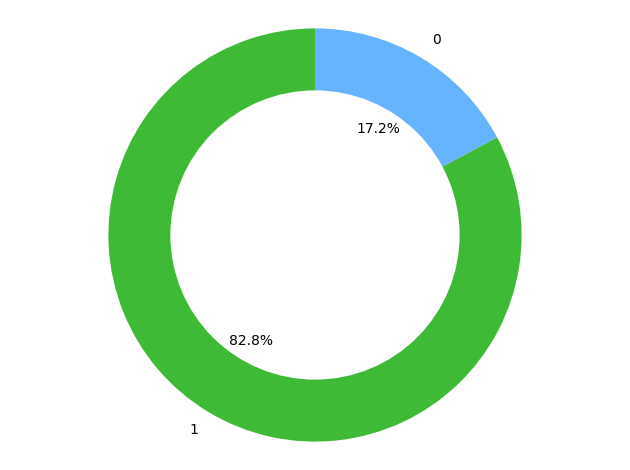

In [ ]:
from collections import Counter

# See the data number of sentence in each category
cnt = Counter(y_train)
cnt = dict(cnt)
print(cnt)

labels = list(cnt.keys())
sizes = list(cnt.values())
colors = ['#3fba36', '#66b3ff','#ffcc99','#ff9999', '#d44444']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')
plt.tight_layout()
# Decomment following line if you want to save the figure
# plt.savefig('distribution.png')
plt.show()


###Preprocessing

In [ ]:
puncs = ['،', '.', ',', ':', ';', '"']
normalizer = Normalizer()
lemmatizer = Lemmatizer()

# turn a doc into clean tokens
def clean_doc(doc):
    doc = normalizer.normalize(doc) # Normalize document using Hazm Normalizer
    tokenized = word_tokenize(doc)  # Tokenize text
    tokens = []
    for t in tokenized:
      temp = t
      for p in puncs:
        temp = temp.replace(p, '')
      tokens.append(temp)
    # tokens = [w for w in tokens if not w in stop_set]    # Remove stop words
    tokens = [w for w in tokens if not len(w) <= 1]
    tokens = [w for w in tokens if not w.isdigit()]
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # Lemmatize sentence words using Hazm Lemmatizer
    tokens = ' '.join(tokens)
    return tokens

In [ ]:
# Apply preprocessing step to training data
train_docs = np.empty_like(x_train)
for index, document in enumerate(x_train):
  train_docs[index] = clean_doc(document)

# Applying preprocessing step to test data
test_docs = np.empty_like(x_test)
for index, document in enumerate(x_test):
  test_docs[index] = clean_doc(document)

##Load the model
Import the model from google drive, and then unzip it

In [ ]:
import zipfile
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
zip_file_path = '/content/drive/MyDrive/bert_pretrained_model.zip'
# Create a directory to extract the contents
extract_path = '/content/bert_pretrained_model/'
os.makedirs(extract_path, exist_ok=True)

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Now loading the model and tokenizer
For tokenizer we should make a dir and upload the vocab.txt we previously achieved, there. I did this manually

In [ ]:
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from transformers import BertForMaskedLM , BertModel
# Load the saved BERT model
bert_model = BertModel.from_pretrained(os.path.join("bert_pretrained_model", "final_model"))

Some weights of BertModel were not initialized from the model checkpoint at bert_pretrained_model/final_model and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
%load_ext tensorboard
%tensorboard --logdir "bert_pretrained_model/runs"

In [ ]:
tokenizer_output_dir = "bert_tokenizer"
os.mkdir(tokenizer_output_dir)

In [ ]:
from transformers import BertTokenizerFast
# Load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained(tokenizer_output_dir, max_len = 512)

##Classifiers

###Define the classifier

In [ ]:
# Define your MLP classifier
import torch.nn as nn

class MLPClassifier(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.mlp = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        # nn.Linear(hidden_size, 32),
        # nn.ReLU(),
        nn.Linear(hidden_size, output_size),
        #nn.Sigmoid()
    )

  def forward(self, x):
    return self.mlp(x)

In [ ]:
# import torch
# import torch.nn as nn

# # Define your classifier (MLP)
# class MLPClassifier(nn.Module):
#   def __init__(self, input_size: int, output_size: int, hidden_units_list: list):
#     super().__init__()
#     layers = []

#     # Add input layer
#     layers.append(nn.Linear(input_size, hidden_units_list[0]))
#     layers.append(nn.ReLU())
#     layers.append(nn.Dropout(p=0.1))

#     # Add hidden layers
#     for i in range(1, len(hidden_units_list)):
#       layers.append(nn.Linear(hidden_units_list[i - 1], hidden_units_list[i]))
#       layers.append(nn.ReLU())
#       #layers.append(nn.Dropout(p=0.2))

#     # Add output layer
#     layers.append(nn.Linear(hidden_units_list[-1], output_size))

#     self.model = nn.Sequential(*layers)

#   def forward(self, x):
#     return self.model(x)

###Set Parameters and Tokenize Data

In [ ]:
# Assuming pooled_representation has been computed

# Tokenize train_docs and test_docs using the trained tokenizer
train_tokenized = tokenizer(train_docs.tolist(),max_length=512, truncation=True, padding=True,
                            return_tensors='pt')

test_tokenized = tokenizer(test_docs.tolist(),max_length=512, truncation=True, padding=True,
                           return_tensors='pt')

###Create a custom dataset


In [ ]:
from torch.utils.data import DataLoader , Dataset
# Create custom dataset
class CustomDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs["input_ids"])

    def __getitem__(self, idx):
        return {
            "input_ids": self.inputs["input_ids"][idx],
            "attention_mask": self.inputs["attention_mask"][idx],
            "labels": torch.tensor(self.labels[idx], dtype=torch.float32)
        }


In [ ]:
batch_size = 64
# Create DataLoader
train_dataset = CustomDataset(train_tokenized, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Create DataLoader
test_dataset = CustomDataset(test_tokenized, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

###Initialize MLP Classifier and Define Loss Function and Optimizer

In [ ]:
# Initialize MLP classifier
input_size = bert_model.config.hidden_size  # Get the size of the pooled representation
hidden_units = 256  # Adjust as needed
output_size = 1  # Binary classification, 1 output unit
learning_rate = 0.1
torch.manual_seed(42)
classifier = MLPClassifier(input_size=input_size, hidden_size=hidden_units, output_size=output_size)

# remove the pooler layer in bert
bert_model.pooler = None

# Move your model and data loaders to the selected device
bert_model.to(device)
classifier.to(device)

# # Freeze all BERT layers
# for param in bert_model.parameters():
#     param.requires_grad = False

# BCE loss
criterion = torch.nn.BCEWithLogitsLoss()
# Specify the parameters to be optimized
optimizer = torch.optim.AdamW([
    {'params': bert_model.parameters(), 'lr': learning_rate},
    {'params': classifier.parameters(), 'lr': learning_rate},
])

###Training loop

In [ ]:
accumulation_steps = 8  # Accumulate gradients over 8 batches

for epoch in range(5):

    train_loss = 0.0
    test_loss = 0.0
    print("epoch = ", epoch + 1)
    print("---------------------------------------")

    # Training
    for batch_idx, batch in enumerate(train_loader):
        inputs = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        classifier.train()
        bert_model.train()

        bert_outputs = bert_model(input_ids=inputs, attention_mask=attention_mask)
        bert_last_hidden_states = bert_outputs.last_hidden_state

        classifier_outputs = classifier(bert_last_hidden_states[:, 0, :])
        loss = criterion(classifier_outputs, labels.unsqueeze(dim=1))
        loss = loss / accumulation_steps  # Normalize the loss if using gradient accumulation
        loss.backward()

        # Update parameters every accumulation_steps batches
        if (batch_idx + 1) % accumulation_steps == 0 or batch_idx == len(train_loader) - 1:
            optimizer.zero_grad()
            optimizer.step()

        train_loss += loss.item()

    # Calculate average loss per batch for training
    train_loss = train_loss / len(train_loader)
    print(f"train loss per batch = {train_loss}")

    # Validation
    bert_model.eval()
    classifier.eval()

    with torch.inference_mode():
        for batch_idx, batch in enumerate(test_loader):
            inputs = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            bert_outputs = bert_model(input_ids=inputs, attention_mask=attention_mask)
            bert_last_hidden_states = bert_outputs.last_hidden_state
            classifier_outputs = classifier(bert_last_hidden_states[:, 0, :])
            loss = criterion(classifier_outputs, labels.unsqueeze(dim=1))
            test_loss += loss.item()

        # Calculate average loss per batch for testing
        test_loss = test_loss / len(test_loader)
        print(f"test loss per batch = {test_loss}")


epoch =  1
---------------------------------------


OutOfMemoryError: ignored

In [ ]:
# Print initial GPU memory usage
initial_memory = torch.cuda.memory_allocated()
print(f"Initial GPU memory: {initial_memory / (1024**3):.2f} GB")

# Your training or inference code here

# After completing a batch or an epoch, free up GPU memory
torch.cuda.empty_cache()

# Print GPU memory usage after emptying the cache
final_memory = torch.cuda.memory_allocated()
print(f"Final GPU memory: {final_memory / (1024**3):.2f} GB")

Initial GPU memory: 12.68 GB
Final GPU memory: 12.68 GB


In [ ]:
epochs = 3
# Training loop
classifier.train()
# set the train loss value
train_loss = 0.0
for epoch in range(epochs):
    for batch in train_loader:
        inputs = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass through BERT
        with torch.no_grad():
            bert_outputs = bert_model(input_ids=inputs, attention_mask=attention_mask)
            pooled_representation = torch.mean(bert_outputs["logits"], dim=1)


        # Forward pass through MLP classifier
        outputs = classifier(pooled_representation)
        # calculate and accumulate the loss
        loss = criterion(outputs,labels.float().unsqueeze(dim =1))
        train_loss += loss.item()

        # set optimizer zero grad
        optimizer.zero_grad()

        # loss backwards
        loss.backward()

        # optimizer step
        optimizer.step()

        # get average loss per batch
        train_loss = train_loss / len(train_loader)
        break
        # # Compute loss and backpropagate
        # loss = criterion(outputs, labels)
        # optimizer.zero_grad()
        # loss.backward()
        # optimizer.step()


###Making a grid
Making a grid to train multiple networks

In [ ]:
param_grid = {
  'hidden_units_list': [[32],[64],[128],[256],[512],
                        [32,16],
                        [64,16],[64,32],
                        [128,16],[128,32],[128,64],
                        [256,16],[256,32],[256,64],[256,128],
                        [512,16],[512,32],[512,64],[512,128],[512,256],
                        [512,256,128],[256,128,64],[128,64,32],[512,128,64],[512,128,32],
                        [256,128,32],[128,32,32],[512,64,32],[256,64,32]
                        ],
  'learning_rate': [0.001, 0.01]
}

###Feed the data to BERT model and get the hidden states

In [ ]:
# Set BERT model to evaluation mode
model.eval()
# Extract input tensors from the BERT model
with torch.no_grad():
    train_outputs = model(**train_tokenized)
    test_outputs = model(**test_tokenized)

In [ ]:
train_bert_embeddings = train_outputs.last_hidden_state[:, 0, :]  # Assuming you want to use the [CLS] token
test_bert_embeddings = test_outputs.last_hidden_state[:, 0, :]

# XLnet pre-training

## Initial imports

In [ ]:
import os
from tokenizers import XLNetWordPieceTokenizer
from transformers import XLNetLMHeadModel, XLNetConfig
from transformers import DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
from datasets import load_dataset
from transformers import TrainerCallback
from torch.utils.data import DataLoader
import torch
import logging

## Importing dataset from huggingface hub

In [ ]:
from datasets import load_dataset

# You should just change this part in order to download your
# parts of corpus.
indices = {
    "train": [5, 1, 2],
    "test": [0, 2]
}

N_FILES = {
    "train": 126,
    "test": 3
}
_BASE_URL = "https://huggingface.co/datasets/SLPL/naab/resolve/main/data/"
data_url = {
    "train": [_BASE_URL + "train-{:05d}-of-{:05d}.txt".format(x, N_FILES["train"]) for x in range(N_FILES["train"])],
    "test": [_BASE_URL + "test-{:05d}-of-{:05d}.txt".format(x, N_FILES["test"]) for x in range(N_FILES["test"])],
}
for index in indices['train']:
    assert index < N_FILES['train']
for index in indices['test']:
    assert index < N_FILES['test']
data_files = {
    "train": [data_url['train'][i] for i in indices['train']],
    "test": [data_url['test'][i] for i in indices['test']]
}
print(data_files)
dataset = load_dataset('text', data_files=data_files, use_auth_token=False)

## Setting paths and file names

In [ ]:
# Set your paths and file names
data_files = ["path/to/your_dataset_file.txt"]
tokenizer_output_dir = "path/to/xlnet_tokenizer"
pretrained_model_output_dir = "path/to/xlnet_pretrained_model"

## Making files for trainging the tokenizer

In [ ]:
# Extract text data from the dataset
texts = dataset['train']['text']  # Assuming you have a 'text' column in your dataset

# Save the text data to a temporary file
temp_file_path = 'temp_dataset_file.txt'
with open(temp_file_path, 'w', encoding='utf-8') as file:
    for text in texts:
        file.write(text + '\n')

# Training a WordPiece Tokenizer
files = [temp_file_path]

## Training a wordPiece Tokenizer

In [ ]:
# Training a WordPiece Tokenizer
files = [temp_file_path]

# Parameters for Tokenizer Training
vocab_size = 30000
min_frequency = 2
max_length = 128
special_tokens = ["<pad>", "<mask>", "<cls>", "<sep>", "<unk>"]

# Initialize the WordPiece tokenizer for XLNet
tokenizer = XLNetWordPieceTokenizer()

# Train the tokenizer
tokenizer.train(
    files=files,
    vocab_size=vocab_size,
    min_frequency=min_frequency,
    show_progress=True,
    special_tokens=special_tokens,
)

# Save the trained tokenizer
tokenizer.save_model(tokenizer_output_dir)

# Save the trained tokenizer
model_path = "pretrained_xlnet_tokenizer"
# make the directory if not already there
if not os.path.isdir(model_path):
    os.mkdir(model_path)

# Save the trained tokenizer
tokenizer.save_model(tokenizer_output_dir)

# Clean up: Remove the temporary file
os.remove(temp_file_path)

## Tokenizing the dataset

In [ ]:
# Load tokenizer after training
tokenizer = XLNetWordPieceTokenizer(f"{tokenizer_output_dir}/vocab.json", f"{tokenizer_output_dir}/merges.txt")

In [ ]:
# Tokenizing the data using dataset.map()
def tokenize_function(examples):
    return tokenizer(examples['text'], padding=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

## Model Configuration

In [ ]:
# Model Configuration
model_config = XLNetConfig(
    vocab_size=vocab_size,
    d_model=768,  # Adjust as needed
    n_head=12,  # Adjust as needed
    num_layers=12,  # Adjust as needed
    max_position_embeddings=max_length,
)

# Model Initialization
model = XLNetLMHeadModel(config=model_config)

## Data Collator

In [ ]:
# Data Collator for Language Modeling
class CustomDataCollator(DataCollatorForLanguageModeling):
  def collate_batch(self, batch):
    input_ids = torch.stack([torch.tensor(example['input_ids']) for example in batch])
    attention_mask = torch.stack([torch.tensor(example['attention_mask']) for example in batch])
    labels = torch.stack([torch.tensor(example['input_ids']) for example in batch])
    return {
      'input_ids': input_ids,
      'attention_mask': attention_mask,
      'labels': labels
    }


## Callback

In [ ]:
# Define a custom callback for monitoring
class CustomCallback(TrainerCallback):
  def __init__(self):
    super().__init__()

  def on_step_end(self, args, state, control, model, optimizer, scheduler, **kwargs):
    if state.global_step % args.logging_steps == 0:
      logging.info(f"Step {state.global_step}: Loss = {state.log_metrics['loss']}")

## Training Arguments

In [ ]:
# Training Arguments
training_args = TrainingArguments(
    output_dir=pretrained_model_output_dir,
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    save_steps=1000,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=500,
)

In [ ]:
# Tokenized data for training
train_inputs = {
    "input_ids": tokenized_dataset["input_ids"],
    "attention_mask": tokenized_dataset["attention_mask"],
}

## Trainer Initialazation

In [ ]:
# Trainer Initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_inputs,
    data_collator=CustomDataCollator(tokenizer=tokenizer, mlm=True, mlm_probability=0.15),
    callbacks=[CustomCallback()],
)

In [ ]:
# Train the model
trainer.train()

# Save the final pre-trained model
trainer.save_model(os.path.join(pretrained_model_output_dir, "final_model"))